# Image Seach Engine Using BOVW

## Imports

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

from sklearn.metrics import precision_recall_fscore_support

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data = None
train_labels = []

path = '/content/drive/MyDrive/Classroom/Computer Vision/'

for i in range(1, 6):
    data_dict = unpickle(path + f'cifar-10-batches-py/data_batch_{i}')
    if i == 1:
        train_data = data_dict[b'data']
    else:
        train_data = np.vstack((train_data, data_dict[b'data']))
    train_labels += data_dict[b'labels']

train_data = train_data.reshape((len(train_data), 3, 32, 32)).transpose(0, 2, 3, 1)
train_data = train_data.astype(np.float32) / 255.0
train_labels = np.array(train_labels)


In [ ]:


test_dict = unpickle(path + 'cifar-10-batches-py/test_batch')
test_data = test_dict[b'data']
test_labels = test_dict[b'labels']

test_data = test_data.reshape((len(test_data), 3, 32, 32)).transpose(0, 2, 3, 1)
test_data = test_data.astype(np.float32) / 255.0
test_labels = np.array(test_labels)

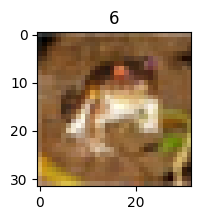

In [ ]:
plt.figure(figsize = (15,2))
plt.imshow( train_data[0])
plt.title( train_labels[0])
plt.show()

In [ ]:
# converting to grayscale
from skimage.color import rgb2gray

train_data = rgb2gray(train_data)
test_data = rgb2gray(test_data)


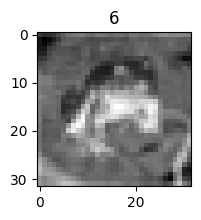

In [ ]:
plt.figure(figsize = (15,2))
plt.imshow( train_data[0], cmap='gray')
plt.title( train_labels[0])
plt.show()

## Building Vocabulary

In [ ]:
# Choose a subset of the training images to extract local features from
subset_indices = np.random.choice(len(train_data), size=10000, replace=False)
subset_data = train_data[subset_indices]

In [ ]:
subset_int_data = []
for float_image in subset_data:
    uint8_image = (float_image * 255).astype('uint8')
    subset_int_data.append(uint8_image)

In [ ]:
train_data_int = []
test_data_int = []

for float_image in train_data:
    uint8_image = (float_image * 255).astype('uint8')
    train_data_int.append(uint8_image)


for float_image in test_data:
    uint8_image = (float_image * 255).astype('uint8')
    test_data_int.append(uint8_image)


### Using Local Binary pattern with 100 clusters and 1000 clusters

In [ ]:


lbp_features = []
for i in range(len(subset_data)):
    image = subset_data[i]
    lbp = local_binary_pattern(image, P=8, R=1)
    lbp_histogram, _ = np.histogram(lbp, bins=256, range=(0, 255), density=True)
    lbp_features.append(lbp_histogram)
lbp_features = np.array(lbp_features)

kmeans_lbp_100 = KMeans(n_clusters=100, random_state=0).fit(lbp_features)
visual_vocabulary_lbp_100 = kmeans_lbp_100.cluster_centers_

kmeans_lbp_1k = KMeans(n_clusters=1000, random_state=0).fit(lbp_features)
visual_vocabulary_lbp_1k = kmeans_lbp_1k.cluster_centers_



/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Using SIFT with 100 clusters and 1000 clusters

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

# Define a function to extract SIFT features from a list of images
def extract_sift_features(images):
    sift_features = []
    for image in images:
      # if image is not None:
        kp, descriptors = sift.detectAndCompute(image, None)
        if descriptors is None:
          continue
        sift_features.append(descriptors)
    return np.vstack(sift_features)

# Extract SIFT features from the training images
sift_features_of_subset = extract_sift_features( subset_int_data)

kmeans_sift_100 = KMeans(n_clusters=100, random_state=42).fit(sift_features_of_subset)
visual_vocabulary_sift_100 = kmeans_sift_100.cluster_centers_

kmeans_sift_1k = KMeans(n_clusters=1000, random_state=42).fit(sift_features_of_subset)
visual_vocabulary_sift_1k = kmeans_sift_1k.cluster_centers_


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Building Histograms

In [ ]:
# Extract local features from each image in the dataset
lbp_features = []
for i in range(len(train_data)):
    image = train_data[i]
    lbp = local_binary_pattern(image, P=8, R=1)
    lbp_histogram, _ = np.histogram(lbp, bins=256, range=(0, 255), density=True)
    lbp_features.append(lbp_histogram)
lbp_features = np.array(lbp_features)

# Compute the nearest visual word for each local feature in each image
visual_word_indices_lbp_100 = kmeans_lbp_100.predict(lbp_features)
visual_word_indices_lbp_1k = kmeans_lbp_1k.predict(lbp_features)

# Build a histogram of visual words for each image
histograms_lbp_100 = []
for i in range(len(train_data)):
    visual_word_histogram, _ = np.histogram(visual_word_indices_lbp_100[i], bins=100, range=(0, 100-1), density=True)
    histograms_lbp_100.append(visual_word_histogram)
histograms_lbp_100 = np.array(histograms_lbp_100)

histograms_lbp_1k = []
for i in range(len(train_data)):
    visual_word_histogram, _ = np.histogram(visual_word_indices_lbp_1k[i], bins=1000, range=(0, 1000-1), density=True)
    histograms_lbp_1k.append(visual_word_histogram)
histograms_lbp_1k = np.array(histograms_lbp_1k)


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

def extract_sift_features(images):
    sift_features = []
    for image in images:
      # if image is not None:
        kp, descriptors = sift.detectAndCompute(image, None)
        if descriptors is None:
          continue
        sift_features.append(descriptors)
    return np.vstack(sift_features)

# Extract SIFT features from the training images
sift_features_all = extract_sift_features( train_data_int)
visual_word_indices_sift_100 = kmeans_sift_100.predict(sift_features_all)
visual_word_indices_sift_1k = kmeans_sift_1k.predict(sift_features_all)

histograms_sift_100 = []
for i in range(len(train_data)):
    visual_word_histogram, _ = np.histogram(visual_word_indices_sift_100[i], bins=100, range=(0, 100-1), density=True)
    histograms_sift_100.append(visual_word_histogram)
histograms_sift_100 = np.array(histograms_sift_100)

histograms_sift_1k = []
for i in range(len(train_data)):
    visual_word_histogram, _ = np.histogram(visual_word_indices_sift_1k[i], bins=1000, range=(0, 1000-1), density=True)
    histograms_sift_1k.append(visual_word_histogram)
histograms_sift_1k = np.array(histograms_sift_1k)


## Processing queried image

In [ ]:
# query = int(input('enter a number less than 10K: '))
query = 100

In [ ]:
# Load the query image
query_image = test_data[query]

# Extract local features from the query image
query_lbp = local_binary_pattern(query_image, P=8, R=1)
query_lbp_100_histogram, _ = np.histogram(query_lbp, bins=256, range=(0, 255), density=True)
query_lbp_1k_histogram, _ = np.histogram(query_lbp, bins=256, range=(0, 255), density=True)

# Compute the nearest visual word for each local feature in the query image
query_visual_word_indices_lbp_100 = kmeans_lbp_100.predict([query_lbp_100_histogram])
query_visual_word_indices_lbp_1k = kmeans_lbp_1k.predict([query_lbp_1k_histogram])

# Build a histogram of visual words for the query image
query_visual_word_histogram_lbp_100, _ = np.histogram(query_visual_word_indices_lbp_100, bins=100, range=(0, 100-1), density=True)
query_visual_word_histogram_lbp_1k, _ = np.histogram(query_visual_word_indices_lbp_1k, bins=1000, range=(0, 1000-1), density=True)



In [ ]:
## sift pre-processing
sift = cv2.xfeatures2d.SIFT_create()

uint8_query_image = (query_image * 255).astype('uint8')
query_kp, query_desc = sift.detectAndCompute(uint8_query_image, None)

# Compute the nearest visual word for each local feature in the query image
query_visual_word_indices_sift_100 = kmeans_sift_100.predict([ query_desc])
query_visual_word_indices_sift_1k = kmeans_sift_1k.predict([ query_desc])

# Build a histogram of visual words for the query image
query_visual_word_histogram_sift_100, _ = np.histogram(query_visual_word_indices_sift_100, bins=100, range=(0, 100-1), density=True)
query_visual_word_histogram_sift_1k, _ = np.histogram(query_visual_word_indices_sift_1k, bins=1000, range=(0, 1000-1), density=True)


## Similarity calculation

In [ ]:
# Compute the chi-squared distances between the query image's histogram and the histograms of visual words for all images in the dataset
chi_squared_distances_lbp_100 = []
chi_squared_distances_lbp_1k = []
for i in range(len(train_data)):
    # Extract local features from the current image in the dataset
    lbp = local_binary_pattern( train_data[i] , P=8, R=1)
    
    # Compute the nearest visual word for each local feature in the current image
    lbp_histogram, _ = np.histogram(lbp, bins=256, range=(0, 255), density=True)
    visual_word_indices_lbp_100 = kmeans_lbp_100.predict([lbp_histogram])
    visual_word_indices_lbp_1k = kmeans_lbp_1k.predict([lbp_histogram])
    
    # Build a histogram of visual words for the current image
    visual_word_histogram_lbp_100, _ = np.histogram(visual_word_indices_lbp_100, bins=100, range=(0, 100-1), density=True)
    visual_word_histogram_lbp_1k, _ = np.histogram(visual_word_indices_lbp_1k, bins=1000, range=(0, 1000-1), density=True)
    
    # Compute the chi-squared distance between the query image's histogram and the histogram of visual words for the current image
    chi_squared_distance_lbp_100 = np.sum((query_visual_word_histogram_lbp_100 - visual_word_histogram_lbp_100) ** 2 / (query_visual_word_histogram_lbp_100 + visual_word_histogram_lbp_100 + 1e-10))
    chi_squared_distances_lbp_100.append(chi_squared_distance_lbp_100)

    chi_squared_distance_lbp_1k = np.sum((query_visual_word_histogram_lbp_1k - visual_word_histogram_lbp_1k) ** 2 / (query_visual_word_histogram_lbp_1k + visual_word_histogram_lbp_1k + 1e-10))
    chi_squared_distances_lbp_1k.append(chi_squared_distance_lbp_1k)

# Sort the distances in ascending order and get the indices of the top 10 images
top_k_indices_lbp_100 = np.argsort(chi_squared_distances_lbp_100)[:10]
top_k_indices_lbp_1k = np.argsort(chi_squared_distances_lbp_1k)[:10]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between query histogram and dataset histograms
similarities_sift_100 = cosine_similarity([query_visual_word_histogram_sift_100], histograms_sift_100)[0]
similarities_sift_1k = cosine_similarity([query_visual_word_histogram_sift_1k], histograms_sift_1k)[0]

# Sort the similarities in descending order and get the top-10 images
top_indices_sift_100 = np.argsort(-similarities_sift_100)[:10]
top_indices_sift_1k = np.argsort(-similarities_sift_1k)[:10]

## Retrieval

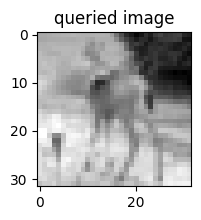


the label of queried image is: 
4


In [ ]:
plt.figure(figsize = (15,2))
plt.imshow( test_data[query], cmap='gray')
plt.title('queried image')
plt.show()
print('\nthe label of queried image is: ')
print( test_labels[query])

### LBP with 100 clusters

In [ ]:
# Retrieve the top-k similar images to the query image
similar_images_lbp_100 = []
for index in top_k_indices_lbp_100:
    image = train_data[index]
    
    # Compute the similarity score between the query image and the current image
    similarity_score = 1 / (1 + chi_squared_distances_lbp_100[index])
    
    # Append the current image and its similarity score to the list of similar images
    similar_images_lbp_100.append((image, similarity_score, index))

# Sort the similar images in descending order based on their similarity scores
similar_images_lbp_100 = sorted(similar_images_lbp_100, key=lambda x: x[1], reverse=True)


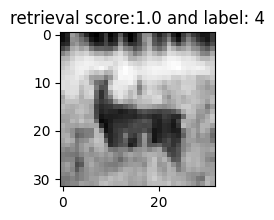

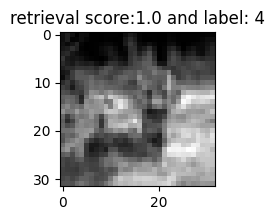

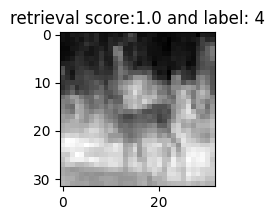

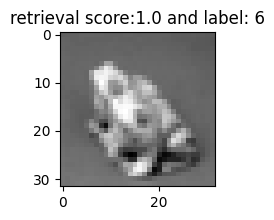

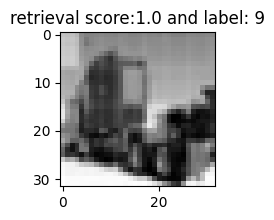

In [ ]:
for image, score, index in similar_images_lbp_100[:5]:
  plt.figure(figsize = (15,2))
  plt.imshow( image, cmap='gray')
  plt.title(f'retrieval score:{score} and label: {train_labels[index]}')
  plt.show()

### LBP with 1000 clusters

In [ ]:
# Retrieve the top-k similar images to the query image
similar_images_lbp_1k = []
for index in top_k_indices_lbp_1k:
    image = train_data[index]
    
    # Compute the similarity score between the query image and the current image
    similarity_score = 1 / (1 + chi_squared_distances_lbp_1k[index])
    
    # Append the current image and its similarity score to the list of similar images
    similar_images_lbp_1k.append((image, similarity_score, index))

# Sort the similar images in descending order based on their similarity scores
similar_images_lbp_1k = sorted(similar_images_lbp_1k, key=lambda x: x[1], reverse=True)


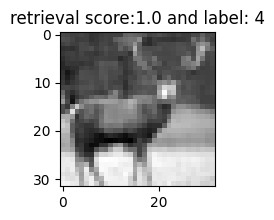

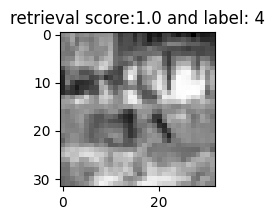

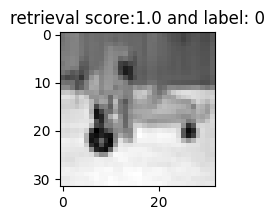

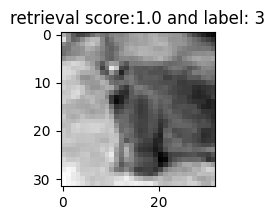

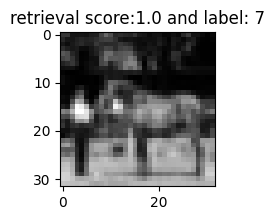

In [ ]:
for image, score, index in similar_images_lbp_1k[:5]:
  plt.figure(figsize = (15,2))
  plt.imshow( image, cmap='gray')
  plt.title(f'retrieval score:{score} and label: {train_labels[index]}')
  plt.show()

### SIFT with 100 clusters

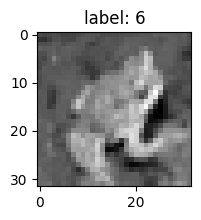

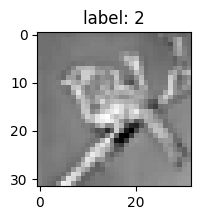

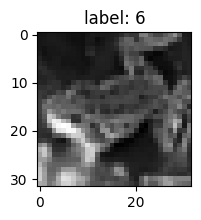

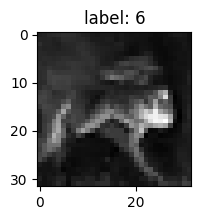

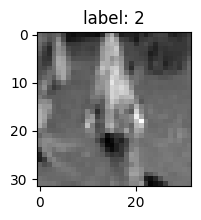

In [ ]:
for index in top_indices_sift_100[:5]:
  plt.figure(figsize = (15,2))
  plt.imshow( test_data[index])
  plt.title( f'label: {train_labels[index}')
  plt.show()


### SIFT with 1000 clusters

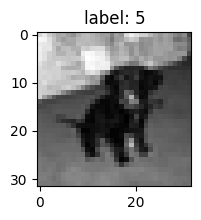

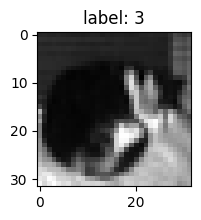

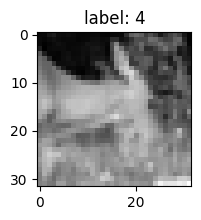

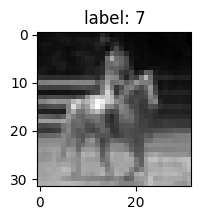

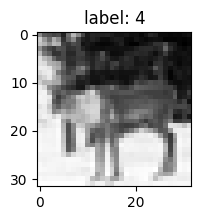

In [ ]:
for index in top_indices_sift_1k[:5]:
  plt.figure(figsize = (15,2))
  plt.imshow( test_data[index])
  plt.title( f'label: {train_labels[index}')
  plt.show()


## Evaluation

In [ ]:
# as LBP is performing better, we will now only concern ourselves with overall performance
'''
recall
visual_word_indices_lbp_100 = kmeans_lbp_100.predict(lbp_features)
visual_word_indices_lbp_1k = kmeans_lbp_1k.predict(lbp_features)
'''


'\nrecall\nvisual_word_indices_lbp_100 = kmeans_lbp_100.predict(lbp_features)\nvisual_word_indices_lbp_1k = kmeans_lbp_1k.predict(lbp_features)\n'

### Pipelining for evaluation

In [ ]:
train_visual_word_histogram = []
for i in range(len(train_data)):
    # Extract local features from the current image in the dataset
    lbp = local_binary_pattern( train_data[i] , P=8, R=1)
    
    # Compute the nearest visual word for each local feature in the current image
    lbp_histogram, _ = np.histogram(lbp, bins=256, range=(0, 255), density=True)
    visual_word_indices_lbp_100 = kmeans_lbp_100.predict([lbp_histogram])
    visual_word_indices_lbp_1k = kmeans_lbp_1k.predict([lbp_histogram])
    
    # Build a histogram of visual words for the current image
    visual_word_histogram_lbp_100, _ = np.histogram(visual_word_indices_lbp_100, bins=100, range=(0, 100-1), density=True)
    train_visual_word_histogram.append( visual_word_histogram_lbp_100)

In [ ]:

def get_labels(number):
  '''
  returns the ground truth and predicted labels for |number| test images
  '''
  gt_labels = []
  pred_labels = []

  for query in range(number):
    query_image = test_data[query]

    # Extract local features from the query image
    query_lbp = local_binary_pattern(query_image, P=8, R=1)
    query_lbp_100_histogram, _ = np.histogram(query_lbp, bins=256, range=(0, 255), density=True)

    query_visual_word_indices_lbp_100 = kmeans_lbp_100.predict([query_lbp_100_histogram])

    query_visual_word_histogram_lbp_100, _ = np.histogram(query_visual_word_indices_lbp_100, bins=100, range=(0, 100-1), density=True)
    chi_squared_distances_lbp_100 = []
    for i in range(len(train_data)):
      visual_word_histogram_lbp_100 = train_visual_word_histogram[i]
      chi_squared_distance_lbp_100 = np.sum((query_visual_word_histogram_lbp_100 - visual_word_histogram_lbp_100) ** 2 / (query_visual_word_histogram_lbp_100 + visual_word_histogram_lbp_100 + 1e-10))
      chi_squared_distances_lbp_100.append(chi_squared_distance_lbp_100)

    top_k_indices_lbp_100 = np.argsort(chi_squared_distances_lbp_100)[:5]

    # Retrieve the top-k similar images to the query image
    top_5_labels = []
    for index in top_k_indices_lbp_100:
      top_5_labels.append( train_labels[index])
    gt_labels.append(test_labels[query])
    pred_labels.append(top_5_labels)
    
  return gt_labels, pred_labels

In [ ]:
def get_metrics(query_labels, retrieved_labels, k):
    precision_list = []
    recall_list = []
    
    for i in range(len(query_labels)):
        relevant = sum([query_labels[i] == l for l in retrieved_labels[i][:k]])
        tp = relevant
        fp = k - relevant
        fn = 1 if relevant == 0 else 0
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    return precision_list, recall_list


In [ ]:
## dimesnion integrity kernel

gt, pred = get_labels(8000)
gt = np.array( gt)
pred = np.array( pred)

print( gt.shape, pred.shape)

(8000,) (8000, 5)


In [ ]:
precision_list = []
recall_list = []

precision_list, recall_list = get_metrics(gt, pred, 3)
# Compute the mean average precision across all query images
precision_at_3 = np.mean(precision_list)
recall_at_3 = np.mean(recall_list)

print(precision_at_3)
print(recall_at_3)

0.18929166666666666
0.42075


In [ ]:
ave_prec = []
ave_recall = []
for k in range(1, 6):
  p_list, r_list = get_metrics( gt, pred, k)
  pres = np.mean( p_list)
  rec = np.mean( r_list)

  ave_prec.append( pres)
  ave_recall.append( rec)



In [ ]:
for i in range(5):
  print(f'when considering {i+1} top images among 5 retireved images; precision: {ave_prec[i]}; recall: {ave_recall[i]}')

when considering 1 top images among 5 retireved images; precision: 0.18175; recall: 0.18175
when considering 2 top images among 5 retireved images; precision: 0.186125; recall: 0.313625
when considering 3 top images among 5 retireved images; precision: 0.18929166666666666; recall: 0.42075
when considering 4 top images among 5 retireved images; precision: 0.1853125; recall: 0.51075
when considering 5 top images among 5 retireved images; precision: 0.18619999999999998; recall: 0.572125


In [ ]:
import matplotlib.pyplot as plt

def plot_pr_curve(precision, recall):
    # Compute average precision
    ap = 0
    for i in range(1, len(precision)):
        ap += (recall[i] - recall[i-1]) * precision[i]

    # Plot the PR curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve (AP={:.2f})'.format(ap))
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()


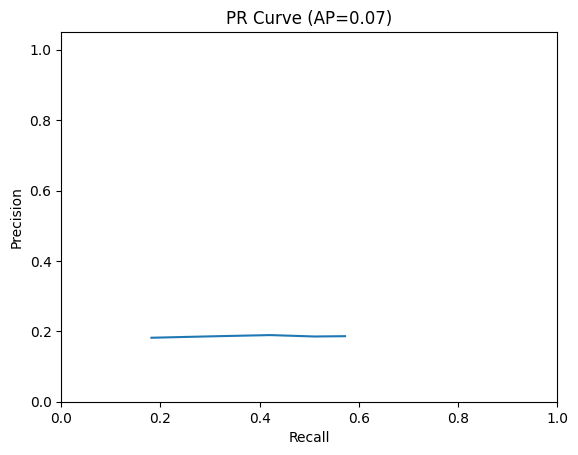

In [ ]:
plot_pr_curve(ave_prec, ave_recall)